# Wheat Seeds Clustering Project

In this project i will use wheat seeds dataset for implementing K-Means clustering algorithm. Dataset can be gathered from UCI Machine Learning Repository.   

Datset consists of 210 records for three different types of wheat seeds (Kama,Rosa and Canadian). Using X-ray technique 7 different measurements recorded as features of seeds. Target value also included in the datset, as we will implement clustering algorithm this will not be used during clustering analysis. It can be used for classification purposes.

_Attribute Information:_  
To construct the data, seven geometric parameters of wheat kernels were measured:    
1.area A,   
2.perimeter P,    
3.compactness C = (4 x pi x A) / P^2,    
4.length of kernel,    
5.width of kernel,    
6.asymmetry coefficient    
7.length of kernel groove.    
All of these parameters were real-valued continuous.


### Make necessary imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import normalized_mutual_info_score,fowlkes_mallows_score,silhouette_score,adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read & Describe data

We will read our data to Pandas DataFrame and then we will create new DataFrame to hold only features. We will not touch target values until we finish our cluster analysis.

Always it is good idea to check your data as a first step. Here some importand points are shape of data, few records from it, some descriptive statistics, null values, type of features and so on. Methods such as head, info, describe will do this for us.

In [2]:
cols = ['area','perimeter','compactness','length','width','asymmetry','groove','class']
df = pd.read_csv('data/seeds_dataset.txt',delimiter='\t',header=None,names=cols)

In [3]:
X = df.loc[:,df.columns[:7]]

In [4]:
X.head()

,area,perimeter,compactness,length,width,asymmetry,groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
area           210 non-null float64
perimeter      210 non-null float64
compactness    210 non-null float64
length         210 non-null float64
width          210 non-null float64
asymmetry      210 non-null float64
groove         210 non-null float64
dtypes: float64(7)
memory usage: 11.6 KB


In [6]:
X.describe()

,area,perimeter,compactness,length,width,asymmetry,groove
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


### Scaling Data
Features with different scales may result poor clustering as we are expecting spherical clusters. For this reaon you should always think about scaling features. For this dataset it is not so important to apply scaling but to show procedure i will continue with applying StandardScaler to our features.

In [7]:
X.loc[:] = StandardScaler().fit_transform(X)

### Vizualize Data
Below you can check scatterplot, histogram and KDE plot for all features. From scatter plots we can see that some features are highly correlated and length of kernel groove seems to seperate data into two clusters. For other features we can look at KDE plots to get intuition about seperation of data points. 

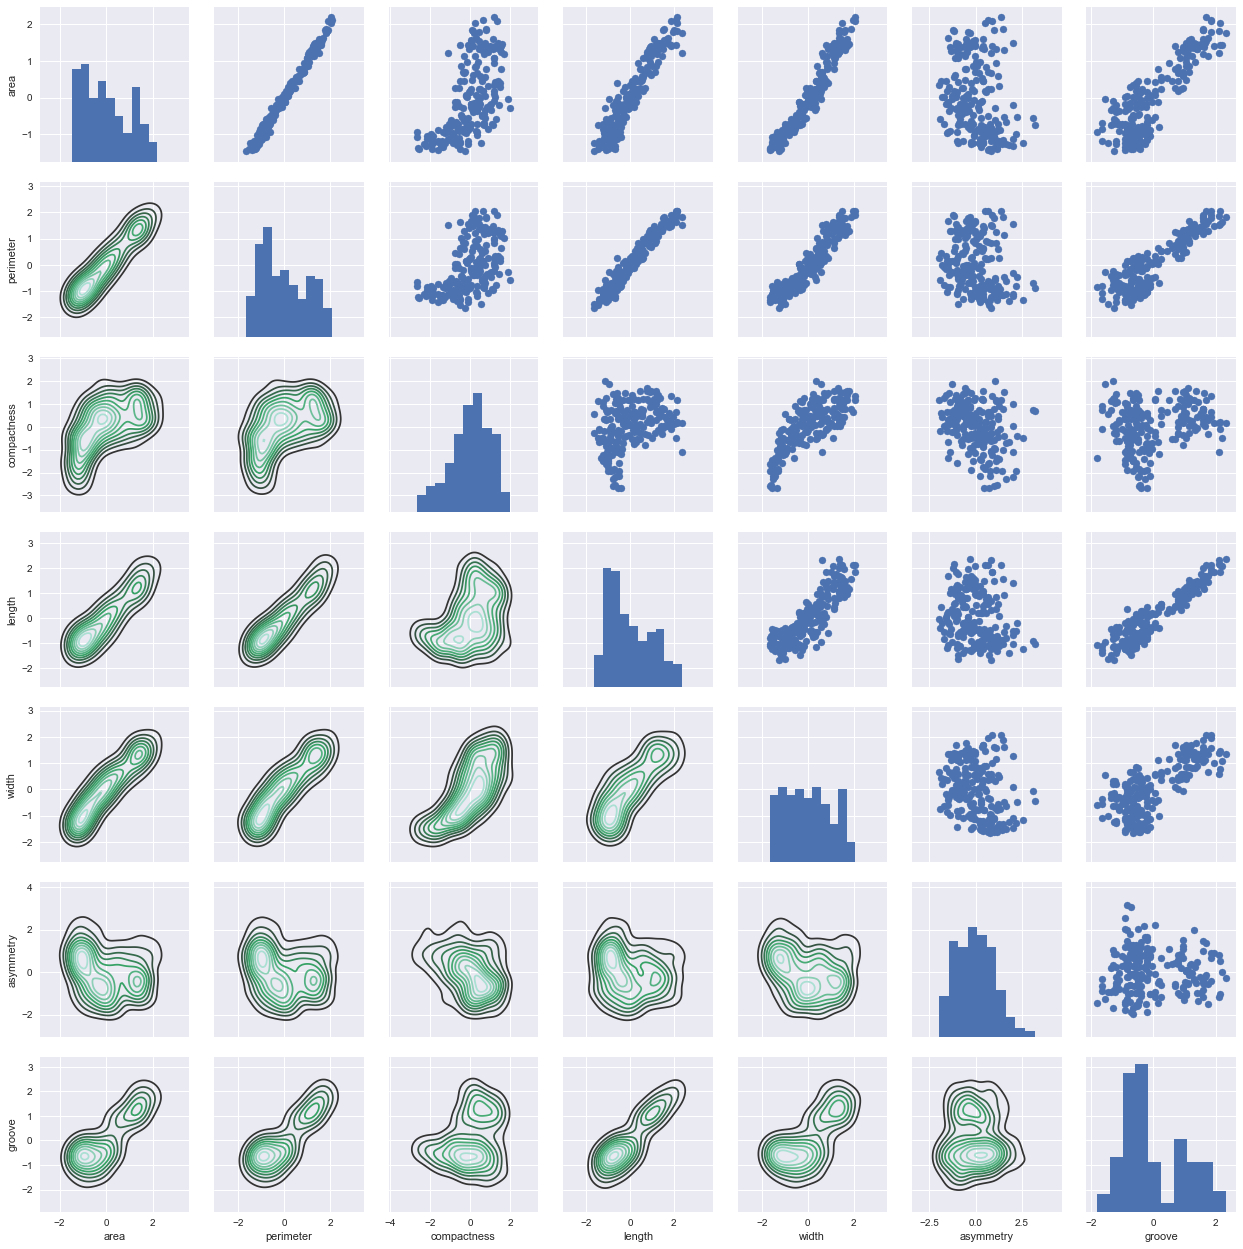

In [8]:
g = sns.PairGrid(data=X)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(plt.hist);

Now we will use heatmap to show correlation between features. As we saw before some features are highly correlated. Such features do not add value for our analysis. For now we will keep all features but later we will check effect of removing some features.

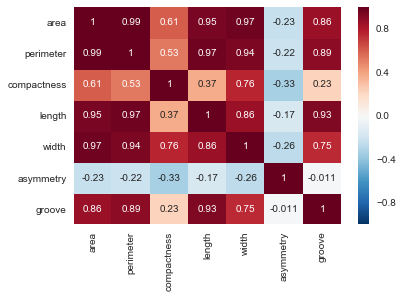

In [9]:
sns.heatmap(X.corr(),annot=True);

### Implementing KMeans
Before implementing KMeans algorithm we need to select proper K value. To do this i will use elbow method. We will try various K values and calculate Sum of Squared Error (SSE) for each model. SSE means squared sum of distance from each point to its cluster center. Later we will plot SSE for each K value and select elbow point with minimum SSE value. Below you can use SSE value available from model by using intertia_ or manually calculate it as shown with commented line.

In [10]:
result = []
for k in range(2,11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    cls=km.predict(X)
    #result.append([k,np.sum(sp.linalg.norm(X-km.cluster_centers_[cls],axis=1)**2)])    
    result.append([k,km.inertia_])

Below we can see that elbow point is where K=3. This means that we can choose number of clusters as three.

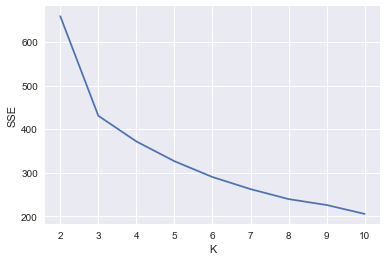

In [11]:
plt.plot([x[0] for x in result],[y[1] for y in result])
plt.ylabel('SSE')
plt.xlabel('K');

Below we build new model by specifying number of cluster as 3. Later by using fit_predict method we are fitting our model with our data and predicting cluster labels for each record. We will add cluster labels to our original DataFrame as new column.

In [12]:
km = KMeans(n_clusters=3)
df['labels'] = km.fit_predict(X)

### Evaluating clustering results

Now it is time to use origninal target variable to check clustering results. This will give us valuable information about performance of our model. You can see that accuracy of our model is about 91%. Only 17 observations are labeled "wrongly".

In [13]:
df.groupby(['class','labels'])['class'].count()
#contingency_matrix(df['class'],df['labels']) #Same result but using sklearn metrics

class  labels
1      0         62
       1          6
       2          2
2      0          5
       2         65
3      0          4
       1         66
Name: class, dtype: int64

Above mentioned method is not right way for evaluation of clustering results.As we are dealing with unsupervised learning alogorithm it is not usual to have labels. Sklearn includes various metrics for evaluating performance of clustering algorithms. Some of them require labels to be known before and some doesn't. Below you can see some of those metrices. Result is not perfect but it seems we have good clustering result. Silhouette score indicates that at some points clusters are overlapping.

In [14]:
adjusted_rand_score(df['class'],df['labels'])

0.7732937360806309

In [15]:
normalized_mutual_info_score(df['class'],df['labels'])

0.72786416201789084

In [16]:
fowlkes_mallows_score(df['class'],df['labels'])

0.84817558346008937

In [17]:
silhouette_score(X,df['labels'])

0.40072705527512992

Now we can use pairplot to see clustering results for each pair of features.

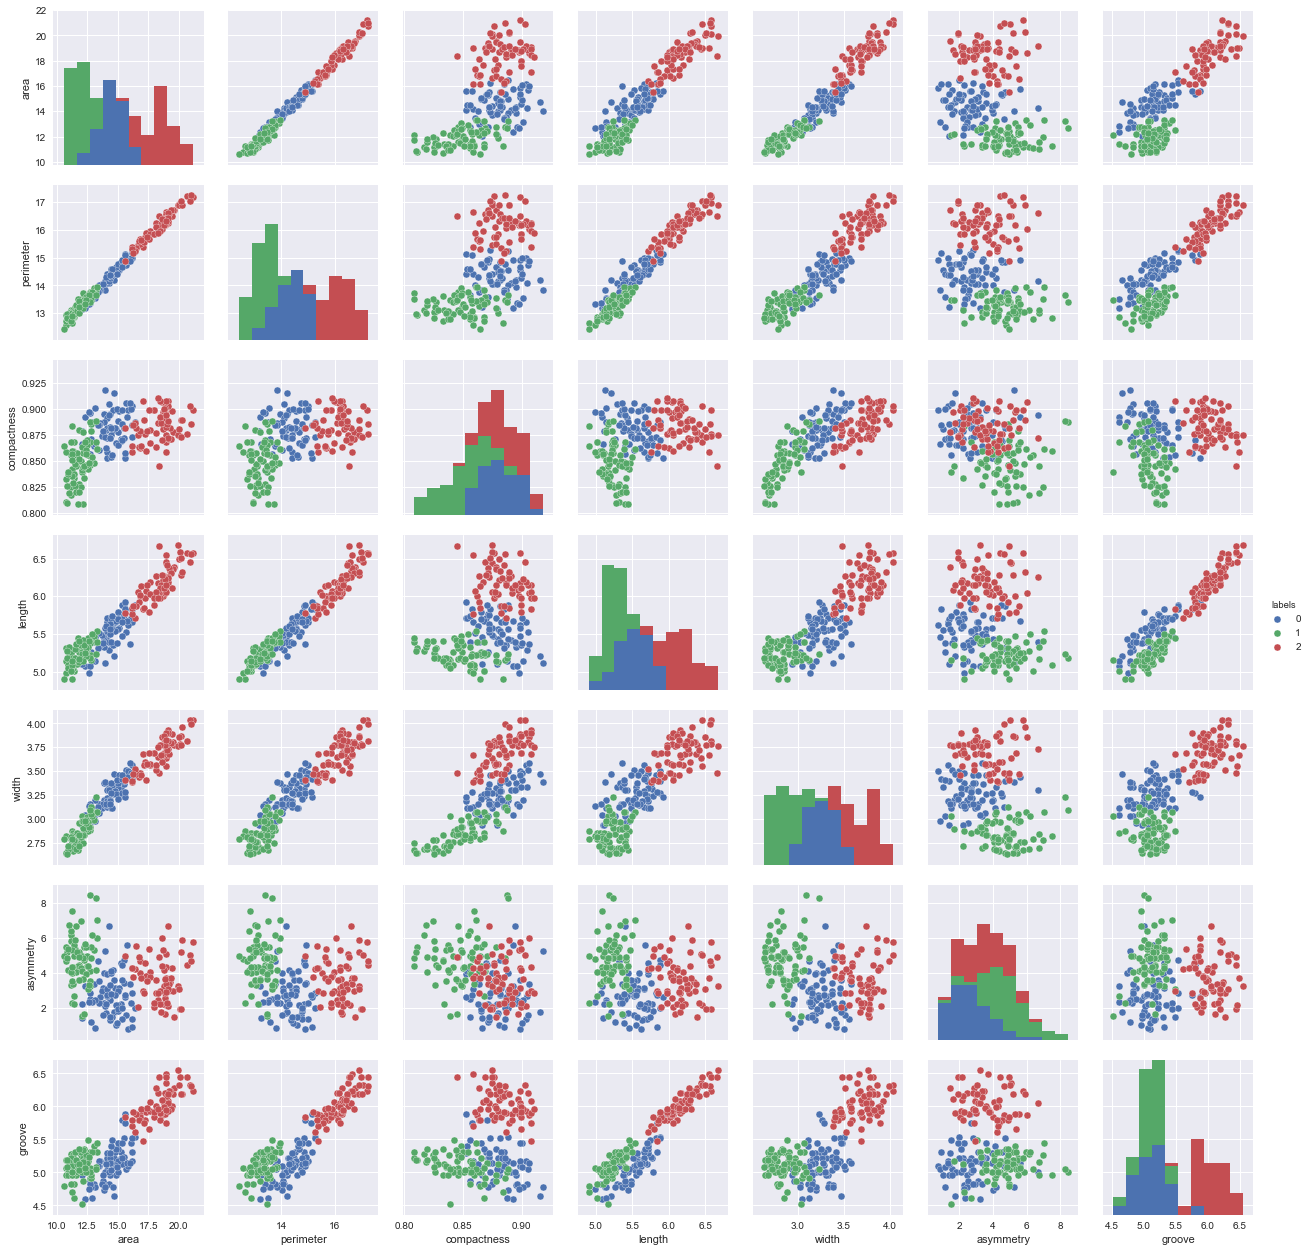

In [18]:
sns.pairplot(data=df,hue='labels',vars=X.columns);

### Dimensionality Reduction
Sometimes it is very difficult to work with high dimentional data. There are methods for reducing number of features and one of them is Principal Component Analysis (PCA). PCA looks for a combination of features that capture well the variance of the original features. We will apply PCA to our data to get two dimentional data.But before doing this we will remove features that are highly correlated (They don't add value in terms of explaining variance).

In [19]:
X.drop(['perimeter','length','width'],axis=1,inplace=True)

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

After implementing PCA lets check how our principal components explain variation in our original data. Below you can see that 1st pricipal component explains 56% of variation in our data while 2nd component explains 28% of variation.

In [21]:
pca.explained_variance_ratio_.round(2)

array([ 0.56,  0.28])

Also we can check how each feature is important for each principal component.

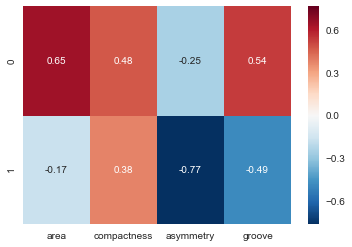

In [22]:
sns.heatmap(pd.DataFrame(pca.components_,columns=X.columns),annot=True);

Lets run our model with data generated as a result of PCA. We will add new column to our DataFrame to keep predected cluster labels after PCA.

In [23]:
km = KMeans(n_clusters=3)
km.fit(X_pca)
df['labels_pca'] = km.predict(X_pca)

By checking our metrices for new model we can say that there is an improvement in avarage. Now we have better speration of clusters.

In [24]:
fowlkes_mallows_score(df['class'],df['labels_pca'])

0.8345869870124033

In [25]:
silhouette_score(X_pca,df['labels_pca'])

0.50700940978035181

### Vizualize Clusters
As a final step we will plot clusters using reduced data.

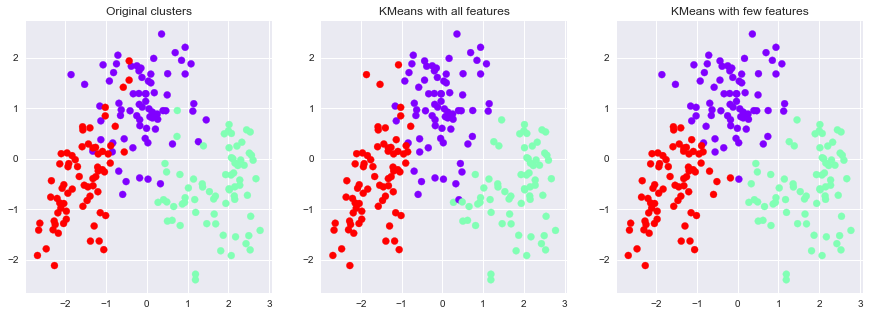

In [26]:
df['labels'] = df['labels'].map({ind:val for ind,val in enumerate(pd.crosstab(df['class'],df['labels']).idxmax())})
df['labels_pca'] = df['labels_pca'].map({ind:val for ind,val in enumerate(pd.crosstab(df['class'],df['labels_pca']).idxmax())})

f,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(X_pca[:,0],X_pca[:,1],c=df['class'],cmap='rainbow')
ax[1].scatter(X_pca[:,0],X_pca[:,1],c=df['labels'],cmap='rainbow')
ax[2].scatter(X_pca[:,0],X_pca[:,1],c=df['labels_pca'],cmap='rainbow')

ax[0].set_title('Original clusters')
ax[1].set_title('KMeans with all features')
ax[2].set_title('KMeans with few features')